In [1]:
import sys
sys.path.insert(0, '/home/niell_lab/Documents/GitHub/FreelyMovingEphys/')

# Organize data

Data to pack into an h5:
* worldcam frames
* spike times for each cell
* cell number (so we can go back to check cluster, tf/sf pref etc.)
* saccade times (gaze left/right, comp left/right)

Do w/ head-fixed and freely moving recordings

Things to play with:
* How much history to use?

## Read it in

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
recpath = '/home/niell_lab/Data/freely_moving_ephys/decoding/0709RT/fm/'
os.listdir(recpath)

['070921_J553RT_control_Rig2_fm1_ephys_props.h5',
 'ModelData_dt016_rawWorldCam_2ds.h5',
 '070921_J553RT_ModelData_dt025_rawWorldCam_2ds.h5']

In [4]:
model_path = os.path.join(recpath, 'ModelData_dt016_rawWorldCam_2ds.h5')

In [5]:
from src.utils.save import save, load

In [6]:
data = load(model_path)

In [230]:
np.sum(np.isnan(data['model_vid_sm_shift']))

93734400

In [14]:
hffm = pd.read_pickle('/home/niell_lab/Data/freely_moving_ephys/batch_files/062022/hffm_062022_gt.pickle')

## Check lengths

In [8]:
data.keys()

dict_keys(['model_active', 'model_dphi', 'model_dth', 'model_eyerad', 'model_gz', 'model_nsp', 'model_phi', 'model_pitch', 'model_roll', 'model_speed', 'model_t', 'model_th', 'model_vid_sm', 'model_vid_sm_shift', 'raw_nsp', 'unit_nums'])

In [92]:
vid = data['model_vid_sm_shift'].copy()[:-1,:,:]

modelT = data['model_t'].copy()

dEye = data['model_dth'].copy()
dEye = dEye[:-1] / np.diff(modelT) # convert to deg/sec

dHead = data['model_gz'].copy()[:-1]*400

spCount = data['model_nsp'].copy()[:-1,:]

dGaze = dEye + dHead

modelT = modelT[:-1]

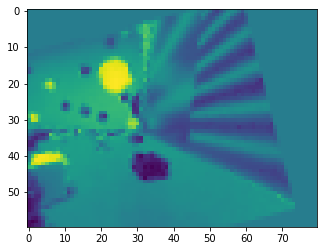

In [233]:
plt.imshow(np.nan_to_num(vid[1000,:,:], nan=300))

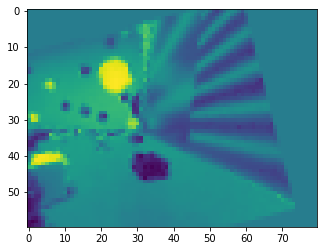

In [232]:
plt.imshow(vid[1000,:,:])

In [93]:
def apply_win_to_comp_sacc(comp, gazeshift, win=0.25):
    bad_comp = np.array([c for c in comp for g in gazeshift if ((g>(c-win)) & (g<(c+win)))])
    comp_times = np.delete(comp, np.isin(comp, bad_comp))
    return comp_times

def keep_first_saccade(eventT, win=0.020):
    duplicates = set([])
    for t in eventT:
        new = eventT[((eventT-t)<win) & ((eventT-t)>0)]
        duplicates.update(list(new))
    out = np.sort(np.setdiff1d(eventT, np.array(list(duplicates)), assume_unique=True))
    return out

In [94]:
saccthresh = { # deg/sec
    'head_moved': 60,
    'gaze_stationary': 120,
    'gaze_moved': 240
}

gazeL = modelT[(dHead > saccthresh['head_moved']) & (dGaze > saccthresh['gaze_moved'])]
gazeR = modelT[(dHead < -saccthresh['head_moved']) & (dGaze < -saccthresh['gaze_moved'])]

compL = modelT[(dHead > saccthresh['head_moved']) & (dGaze < saccthresh['gaze_stationary']) & (dGaze > -saccthresh['gaze_stationary'])]
compR = modelT[(dHead < -saccthresh['head_moved']) & (dGaze > -saccthresh['gaze_stationary']) & (dGaze < saccthresh['gaze_stationary'])]

In [95]:
compL = apply_win_to_comp_sacc(compL, gazeL)
compR = apply_win_to_comp_sacc(compR, gazeR)

In [103]:
gazeL = keep_first_saccade(gazeL); gazeR = keep_first_saccade(gazeR)
compL = keep_first_saccade(compL); compR = keep_first_saccade(compR)

In [115]:
saccades = np.zeros([len(modelT),4])
for xi, x in enumerate([gazeL, gazeR, compL, compR]):
    for t in x:
        ind = np.argmin(np.abs(modelT-t))
        saccades[ind,xi] = 1

## Repackage it all

In [106]:
modelT.shape

(169854,)

In [120]:
vid.shape

(169854, 60, 80)

In [70]:
spCount.shape

(169854, 108)

In [119]:
saccades.shape

(169854, 4)

In [150]:
decoding_data = np.concatenate([modelT[:,np.newaxis],
                                saccades], axis=1)

In [140]:
decoding_data.shape

(169854, 5)

In [161]:
flatvid = np.reshape(vid, [np.size(vid,0), 4800])

In [175]:
decoding_data = {
    'modelT': modelT,
    'stim': flatvid,
    'saccades': saccades,
    'spikes': spCount
}

In [176]:
save('/home/niell_lab/Data/freely_moving_ephys/decoding/data1.h5', decoding_data)

# Training

In [208]:
def train_test_split(data, split=75, start=True):
    train_frac = split/100
    test_frac = 1-train_frac
    
    sz = np.size(data['modelT'])
    train_bool = np.zeros(sz)
    test_bool = np.zeros(sz)
    
    if start is True:
        split_ind = int(np.floor(sz*train_frac))
        train_bool[:split_ind] = 1
        test_bool[split_ind:] = 1
    elif start is False:
        split_ind = int(np.floor(sz*test_bool))
        train_bool[split_ind:] = 1
        test_bool[:split_ind] = 1
        
    train_bool = train_bool.astype(bool)
    test_bool = test_bool.astype(bool)
    
    train = {}; test = {}
    # timestamps
    train['modelT'] = data['modelT'][train_bool]
    test['modelT'] = data['modelT'][test_bool]
    # stim video
    train['stim'] = data['stim'][train_bool]
    test['stim'] = data['stim'][test_bool]
    # saccades
    train['saccades'] = data['saccades'][train_bool]
    test['saccades'] = data['saccades'][test_bool]
    # spike counts
    train['spikes'] = data['spikes'][train_bool]
    test['spikes'] = data['spikes'][test_bool]
    
    return train, test

In [209]:
train_data, test_data = train_test_split(decoding_data)

In [210]:
from sklearn.neural_network import MLPRegressor

In [211]:
regr = MLPRegressor()

In [213]:
train_x = train_data['stim'].copy()
train_x
train_y = train_data['spikes'].copy()

In [214]:
train_x.shape

(127390, 4800)

In [215]:
train_y.shape

(127390, 108)

In [216]:
regr.fit(train_x, train_y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').